In [1]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt

import cv2

import torch
import torch.nn as nn
import torchvision.datasets as datasets
from torch.autograd import Variable
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
from torchvision.utils import save_image

c:\Anaconda\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Anaconda\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# Data handling
TRAIN_DIR = './data_map_cutouts/train4' #'../data__map_cutouts/train_v3'
BATCH_SIZE = 32

In [3]:
to_tensor = transforms.ToTensor()
random_flips_v = transforms.RandomVerticalFlip(0.5)
random_flips_h = transforms.RandomHorizontalFlip(0.5)
to_grayscale = transforms.Grayscale(1)

transform = transforms.Compose([
    to_grayscale,
    to_tensor,
    random_flips_h,
    random_flips_v
])

train_dir = pathlib.Path(TRAIN_DIR)  
train_data = datasets.ImageFolder(root      = train_dir, 
                                  transform = transform)
train_dataLoader = DataLoader(dataset = train_data,
                     batch_size = BATCH_SIZE, 
                     shuffle    = True,
                     drop_last  = True)


torch.Size([32, 1, 128, 128])


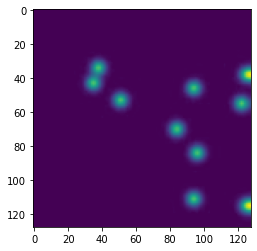

In [4]:
images, labels = next(iter(train_dataLoader))
print(images.shape)
plt.imshow(images[0, 0, :, :].detach().cpu().numpy())

## Model

In [5]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape
        # print(shape)

    def forward(self, x):
        return x.view(x.shape[0], *self.shape)
    
class VAE(nn.Module):
    def __init__(self, latent_dim) -> None:
        super().__init__()
        self.latent_dim = latent_dim
        self.cuda = torch.cuda.is_available
        self.device = torch.device("cuda" if self.cuda else "cpu")
        self.encoder = nn.Sequential(
            nn.Conv2d(
                in_channels   = 1,
                out_channels  = 256,
                kernel_size   = 3,
                stride        = 2,
                padding       = 1
            ),
            nn.ReLU(
                # negative_slope=0.2,
                inplace=True),
            
            nn.BatchNorm2d(num_features = 256,
                           eps          = 0.01,
                           momentum = 0.9),

            nn.Conv2d(
                in_channels   = 256,
                out_channels  = 128,
                kernel_size   = 3,
                stride        = 2,
                padding       = 1
            ),
            nn.ReLU(
                # negative_slope=0.2,
                inplace=True),

            nn.BatchNorm2d(num_features = 128,
                           eps          = 0.01,
                           momentum     = .9),

            nn.Conv2d(
                in_channels   = 128,
                out_channels  = 64,
                kernel_size   = 3,
                stride        = 2,
                padding       = 1
            ),
            nn.ReLU(
                # negative_slope=0.2,
                inplace=True),

            nn.BatchNorm2d(num_features = 64,
                           eps          = 0.01,
                           momentum     = .9),
            nn.Flatten(),
            nn.Linear(in_features  = 64*16**2, 
                      out_features = 1024),
                      
            nn.Linear(in_features  = 1024, 
                      out_features = 2*latent_dim),
        ).to(self.device)

        self.decoder = nn.Sequential(
            nn.Linear(in_features  = latent_dim, 
                      out_features = 2048),
            Reshape((32, 8, 8)),
            nn.BatchNorm2d(num_features = 32,
                           eps          = 0.01, 
                           momentum     = .9),

            nn.ConvTranspose2d(in_channels  = 32,
                      out_channels = 128,
                      kernel_size  = 3,
                      stride       = 2,
                      padding      = 1,
                      output_padding = 1
                      ),
            nn.ReLU(
                # negative_slope = 0.2,
                inplace        = True
            ),
            nn.BatchNorm2d(num_features = 128,
                           eps          = 0.01, 
                           momentum     = .9),

            nn.ConvTranspose2d(in_channels  = 128,
                      out_channels = 64,
                      kernel_size  = 3,
                      stride       = 2,
                      padding      = 1,
                      output_padding = 1
                      ),
            nn.ReLU(
                # negative_slope = 0.2,
                inplace        = True
            ),                        
            nn.BatchNorm2d(num_features = 64,
                           eps          = 0.01, 
                           momentum     = .9),
            
            nn.ConvTranspose2d(in_channels  = 64,
                      out_channels = 32,
                      kernel_size  = 3,
                      stride       = 2,
                      padding      = 1,
                      output_padding = 1
                      ),
            nn.ReLU(
                # negative_slope = 0.2,
                inplace        = True
            ),                        
            nn.BatchNorm2d(num_features = 32,
                           eps          = 0.01, 
                           momentum     = .9),

            nn.ConvTranspose2d(in_channels  = 32,
                      out_channels = 16,
                      kernel_size  = 3,
                      stride       = 2,
                      padding      = 1,
                      output_padding = 1
                      ),
            nn.ReLU(
                # negative_slope = 0.2,
                inplace        = True
            ),                        
            nn.BatchNorm2d(num_features = 16,
                           eps          = 0.01, 
                           momentum     = .9),

            nn.ConvTranspose2d(in_channels  = 16,
                      out_channels = 1,
                      kernel_size  = 3,
                      stride       = 1,
                      padding      = 1,
                      output_padding = 0
                      ),
        ).to(self.device)
    
    def encode(self, x):
        mean = self.encoder(x)[:, :self.latent_dim]
        logvar = self.encoder(x)[:, self.latent_dim:]

        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        # eps ~ N(0,1)
        eps = torch.normal(mean = 0, std=1, size=mean.shape, device="cuda" if self.cuda else "cpu")
        # returning ~ N(mean, exp^(logvar/2))
        return eps * torch.exp(logvar * .5) + mean
    
    def decode(self, z, apply_sigmoid = False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = nn.Sigmoid()(logits).to(self.device)
            return probs
        return logits
    
    def sample(self, z=None):
        if z is None:
            z = torch.normal(mean = 0., std = 1., size=(BATCH_SIZE, self.latent_dim)).to(self.device)
        return self.decode(z, apply_sigmoid=False)
    
    def log_normal_pdf(self, sample, mean, logvar, raxis=1):
        # print("Logvar:", type(logvar))
        if type(logvar) == float and logvar == 0.:
            logvar = torch.FloatTensor([0.]).to(self.device)
        log2pi = np.log(2 * np.pi)
        return torch.sum(
            -0.5 * ((sample - mean)**2. * torch.exp(-logvar) + logvar + log2pi),
            dim=raxis)
    
    def compute_loss(self, x):
        mean, logvar = self.encode(x)
        
        z = self.reparameterize(mean, logvar)
        x_logit = self.decode(z)

        cross_ent = nn.functional.binary_cross_entropy_with_logits(x_logit, x, reduction='none')
        logpx_z = -torch.sum(cross_ent, dim=[1, 2, 3])
        logpz = self.log_normal_pdf(z, 0., 0.)
        logqz_x = self.log_normal_pdf(z, mean, logvar)
        return -torch.mean(logpx_z + logpz - logqz_x)
    
    def train_step(self, x, e_optim, d_optim):
        e_optim.zero_grad()
        d_optim.zero_grad()
        loss = self.compute_loss(x)
        loss.backward()
        e_optim.step()
        d_optim.step()
        return loss
    
    def train(self, dataLoader,
              n_epochs = 100, sample_interval = 100,
              save_interval = 5,
              lr = 0.001, betas=(0.5, 0.9),
              dumping_interval = 1000):
        
        losses = []
        e_optim = torch.optim.Adam(self.encoder.parameters(), lr=lr, betas=betas)
        d_optim = torch.optim.Adam(self.decoder.parameters(), lr=lr, betas=betas)
        for epoch in range(n_epochs):
            for idx, sample in enumerate(dataLoader):
                imgs = sample[0]
                real_imgs = imgs.to(self.device)
                losses.append(self.train_step(real_imgs, e_optim, d_optim).item())
                print(f'\r[Epoch {epoch+1}/{n_epochs}] [Batch {(idx+1) % len(dataLoader)}/{len(dataLoader)}] [Loss: {losses[-1]:.3f}]\t', end='')
        plt.plot(losses)
    
    def save_states(self, encoder_state_file, decoder_state_file):
        
        torch.save(self.encoder.state_dict(), encoder_state_file)
        torch.save(self.decoder.state_dict(), decoder_state_file)

model = VAE(20)

In [6]:
z = np.random.normal(0, 1, (10, 1, 128, 128))
z = torch.cuda.FloatTensor(z)
gen_enc = model.encoder(z)
print(gen_enc.shape)

gen_loss = model.compute_loss(z)
gen_loss

torch.Size([10, 40])


tensor(20271.2793, device='cuda:0', grad_fn=<NegBackward0>)

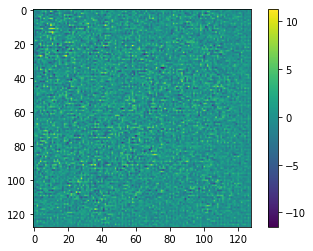

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [7]:
gen_img = model.decoder(gen_enc[:, :model.latent_dim]).detach().cpu().numpy()
gen_img.shape

plt.imshow(gen_img[0, 0, :, :])
plt.colorbar()
plt.show()
plt.imshow(z[0, 0, :, :].detach().cpu().numpy())
plt.colorbar()
plt.show()

[Epoch 2/2] [Batch 0/156] [Loss: 3113.284]	]	

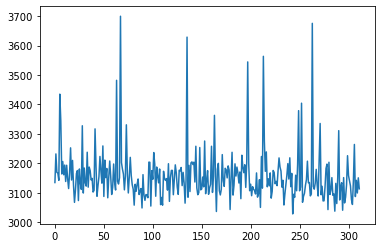

In [86]:
model.train(n_epochs=2, dataLoader=train_dataLoader, lr=2e-6)

In [106]:
# model.save_states('./multiple_3_blob_encoder', './multiple_3_blob_decoder') 
    # Model multiple_3_blob_encoder is saved

In [8]:
try:
    model.encoder.load_state_dict(torch.load('./multiple_3_blob_encoder', map_location=model.device))
    model.decoder.load_state_dict(torch.load('./multiple_3_blob_decoder', map_location=model.device))
except Exception:
    print("Failed to load states")

In [9]:
def reduce_resolution(image, scale_factor):
    width = int(image.shape[1] / scale_factor)
    height = int(image.shape[0] / scale_factor)
    resized_image = cv2.resize(image, (width, height), interpolation=cv2.INTER_LINEAR)
    return resized_image

In [10]:
def sharpen_image(image, strength):
    # Create a sharpening kernel
    kernel = np.array([[-strength, -strength, -strength],
                       [-strength, 1 + 8 * strength, -strength],
                       [-strength, -strength, -strength]])
    
    # Apply the sharpening kernel to the image
    sharpened_image = cv2.filter2D(image, -1, kernel)
    
    return sharpened_image

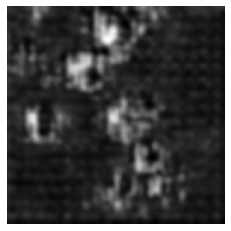

In [55]:
# z = torch.normal(mean = 0., std=1.0, size=(BATCH_SIZE, model.latent_dim)).to(model.device)
# with torch.no_grad():
#     gen_img = model.decode(z, apply_sigmoid=True)[0, 0, :, :].detach().cpu().numpy()

# gen_img = cv2.GaussianBlur(gen_img, (7,7), 0)
# gen_img = reduce_resolution(gen_img, scale_factor=2)

# gen_img = gen_img - np.min(gen_img)
# gen_img = gen_img / np.max(gen_img)

plt.imshow((gen_img), cmap='Greys_r')
# plt.colorbar()
plt.axis('off')
plt.show()
# print(gen_img)

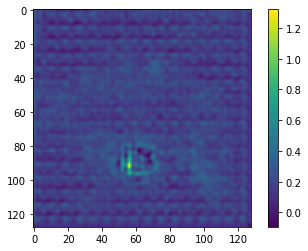

In [15]:
plt.imshow(sharpen_image((gen_img)-np.min(gen_img), 0.2))
plt.colorbar()
plt.show()

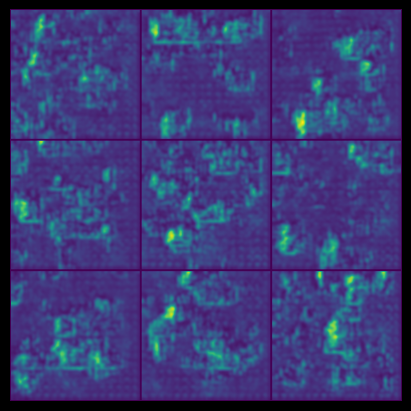

In [16]:
def plot_latent_images(model, n=5, epoch=10, im_size=128+2, save=False):
    img_w = im_size * n
    img_h = im_size * n

    image = np.zeros((img_h, img_w))

    norm = torch.distributions.Normal(0, 1)
    grid_x = norm.icdf(torch.linspace(0.05, 0.95, n))
    grid_y = norm.icdf(torch.linspace(0.05, 0.95, n))

    # print(grid_x.shape)

    for i, y_i in enumerate(grid_x):
        for j, x_j in enumerate(grid_y):
            z = torch.tensor([[x_j, y_i]])
            z = torch.cat([z, torch.normal(0., 1., size=(1, (model.latent_dim-2)))], dim=1).to(device=model.device)
            # print(z.shape)
            x_decoded = model.decode(z=z, apply_sigmoid=True)

            digit = x_decoded[0].view(im_size-2, im_size-2).detach().cpu().numpy()
            digit = cv2.GaussianBlur(digit, (7,7), 0)
            digit = np.pad(digit, ((1,1), (1,1)), mode='constant', constant_values=0)
            # plt.imshow(digit)
            # plt.show()

            # digit = digit - np.min(digit)
            # digit = digit / np.max(digit)

            # print(np.max(digit), np.min(digit))

            image[i * im_size:(i+1)*im_size, j*im_size:(j+1)*im_size] = digit

    plt.figure(constrained_layout = True, dpi=100, facecolor='0.')
    plt.imshow((image))
    plt.axis('off')
    # plt.colorbar()
    plt.show()
plot_latent_images(model, n=3)

In [ ]:
plot_latent_images(model, n=10)

tensor([[0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]], device='cuda:0')


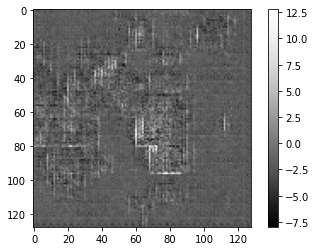

In [17]:
z = torch.ones((1, model.latent_dim)).to(device=model.device)
z[:, 0:5] = 0. 
print(z)
img = model.decode(z)[0, 0, :, :].detach().cpu().numpy()
plt.imshow(img, cmap='Greys_r')
plt.colorbar()
plt.show()

In [18]:
from PIL import Image

SAVING_DIR = 'datasets_for_Statistician/multiple_blobs_VAE_3/generated_data/'
os.makedirs(SAVING_DIR, exist_ok=True)

for n in range(80):
    z = torch.normal(mean = 0., std=1.0, size=(BATCH_SIZE, model.latent_dim)).to(model.device)
    # Generate a batch of images
    gen_imgs = model.decode(z, apply_sigmoid=False)[:, :, :, :].detach().cpu().numpy()
    
        
    for i in range(BATCH_SIZE):
        frame = gen_imgs[i, 0, :, :]
        frame = cv2.GaussianBlur(frame, (7,7), 0)
        frame = frame - np.min(frame)
        frame = frame * 255 / np.max(frame)
        frame = frame.astype(np.uint8)

        img = Image.fromarray(frame)# .convert('RGB')
        print(f'\r{n*BATCH_SIZE + i + 1} / {80 * BATCH_SIZE}', end='')
        img.save(SAVING_DIR + str((n * BATCH_SIZE) + i) + '.jpg')
    
print('\n')        

2560 / 2560



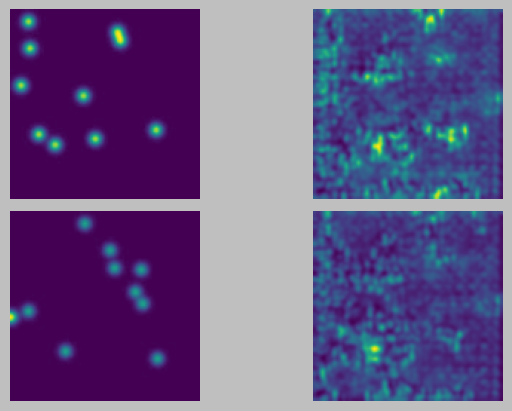

-----FIRST_IMAGE------
Mean: tensor([[-0.1991, -0.8854,  0.4601, -0.7153,  0.0610, -0.0752, -1.5186,  0.0869,
          0.3860,  0.0020, -0.1228, -1.8242,  1.2946,  0.3163,  0.9945,  1.0606,
         -0.6099, -0.5889,  0.2339, -0.4157]], device='cuda:0',
       grad_fn=<SliceBackward0>)
Variance: tensor([[0.0368, 0.0317, 0.0382, 0.0302, 0.0436, 0.0316, 0.0213, 0.0302, 0.0440,
         0.0309, 0.0380, 0.0276, 0.0324, 0.0271, 0.0288, 0.0426, 0.0341, 0.0226,
         0.0384, 0.0351]], device='cuda:0', grad_fn=<ExpBackward0>)
Sampled: tensor([[-0.0678, -0.9146,  0.4232, -1.1084,  0.0663, -0.0435, -1.4596,  0.0501,
          0.0754,  0.0739,  0.0812, -1.8830,  0.9617,  0.3819,  1.2860,  0.7429,
         -0.4676, -0.4557, -0.0788, -0.3859]], device='cuda:0',
       grad_fn=<AddBackward0>)
-----SECOND_IMAGE------
Mean: tensor([[-0.1991, -0.8854,  0.4601, -0.7153,  0.0610, -0.0752, -1.5186,  0.0869,
          0.3860,  0.0020, -0.1228, -1.8242,  1.2946,  0.3163,  0.9945,  1.0606,
         -0.60

In [140]:
# Comparing the input and generated images from the encoded distribution side-by-side

RESOLUTION_SCALE_FACTOR = 1
GAUSSIAN_BLUR_FACTOR = 7
real_i, _ = next(iter(train_dataLoader))
real_i = real_i.detach().cpu()
real_i.shape

real_1 = real_i.numpy()[0:1, 0:1, :, :]
real_2 = real_i.numpy()[16:17, 0:1, :, :]

fig = plt.figure(constrained_layout = True, dpi=100,facecolor='0.75')

plt.subplot(2,2,1)
plt.imshow(real_1[0, 0, :, :])
plt.axis('off')

z_1_m, z_1_v = model.encode(torch.tensor(real_1).to(model.device))

z_1 = model.reparameterize(z_1_m, z_1_v)
gene_1 = nn.Sigmoid()(model.decoder(z_1)).detach().cpu().numpy()[0, 0, :, :]
gene_1 = cv2.GaussianBlur(gene_1, (GAUSSIAN_BLUR_FACTOR,GAUSSIAN_BLUR_FACTOR), 0)
gene_1 = reduce_resolution(gene_1, scale_factor=RESOLUTION_SCALE_FACTOR)

plt.subplot(2,2,2)
plt.imshow(gene_1)
plt.axis('off')


plt.subplot(2,2,3)
plt.imshow(real_2[0, 0, :, :])
plt.axis('off')

z_2_m, z_2_v = model.encode(torch.tensor(real_1).to(model.device))
z_2 = model.reparameterize(z_2_m, z_2_v)
gene_2 = nn.Sigmoid()(model.decoder(z_2)).detach().cpu().numpy()[0, 0, :, :]
gene_2 = cv2.GaussianBlur(gene_2, (GAUSSIAN_BLUR_FACTOR,GAUSSIAN_BLUR_FACTOR), 0)
gene_2 = reduce_resolution(gene_2, scale_factor=RESOLUTION_SCALE_FACTOR)

plt.subplot(2,2,4)
plt.imshow(gene_2)
plt.axis('off')
plt.show()

print("-----FIRST_IMAGE------")
print("Mean:", z_1_m)
print("Variance:", torch.exp(z_1_v))
print("Sampled:", z_1)
print("-----SECOND_IMAGE------")
print("Mean:", z_2_m)
print("Variance:", torch.exp(z_2_v))
print("Sampled:", z_2)


Cos(theta): [[0.]]
Theta: 1.5707973705062865


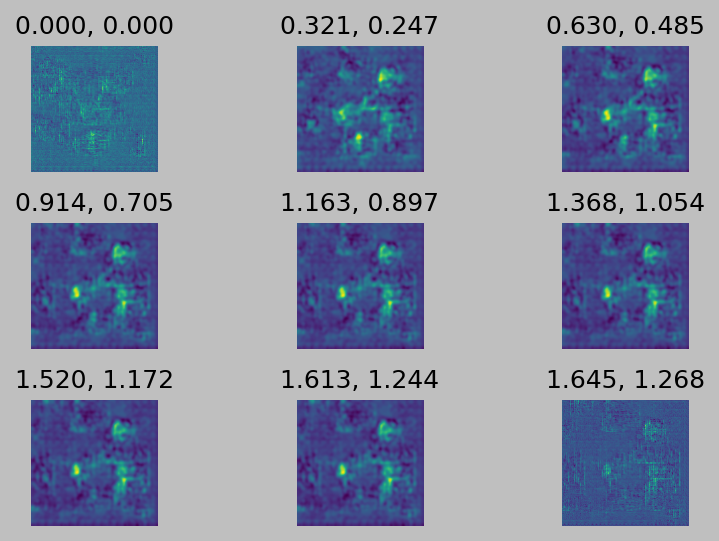

In [143]:
# Trying to interpolate between images
# Comparing the input and generated images from the encoded distribution side-by-side

RESOLUTION_SCALE_FACTOR = 1
# real_i, _ = next(iter(train_dataLoader))
# real_i = real_i.detach().cpu()
# real_i.shape

# real_1 = real_i.numpy()[0:1, 0:1, :, :]
# real_2 = real_i.numpy()[16:17, 0:1, :, :]

# z_1_m, z_1_v = model.encode(torch.tensor(real_1).to(model.device))
# z_2_m, z_2_v = model.encode(torch.tensor(real_1).to(model.device))

z_1_m = torch.normal(0., 1., size=(1, (model.latent_dim))).to(device=model.device)*0.
z_2_m = torch.normal(0., 1., size=(1, (model.latent_dim))).to(device=model.device)

fig = plt.figure(dpi=150,facecolor='0.75')

gen_img = cv2.GaussianBlur(gen_img, (7,7), 0)
plt.subplot(3,3,1)
plt.title(f'{z_1_m[0, 0]:.3f}, {z_1_m[0, 1]:.3f}')
plt.imshow((model.sample(z_1_m)).detach().cpu().numpy()[0, 0, :, :])
plt.axis('off')

gen_img = model.sample(z_2_m).detach().cpu().numpy()[0, 0, :, :]
gen_img = cv2.GaussianBlur(gen_img, (7,7), 0)
plt.subplot(3,3,9)
plt.title(f'{z_2_m[0, 0]:.3f}, {z_2_m[0, 1]:.3f}')
plt.imshow()
plt.axis('off')

z_1_m = z_1_m.detach().cpu().numpy()
z_2_m = z_2_m.detach().cpu().numpy()

theta = z_1_m @ z_2_m.T / ((np.linalg.norm(z_1_m[0, :]) + 1e-6) * (np.linalg.norm(z_2_m[0, :]) + 1e-6))
print("Cos(theta):", theta)
theta = np.arccos(theta[0,0]) + 1e-6
print("Theta:", theta)

for i in range(7):
    l = (i + 1) / 8
    
    fac_1 = np.sin((1 - l)*theta) / np.sin(theta)
    fac_2 = np.sin(l * theta) / np.sin(theta)

    z_mid = z_1_m * fac_1 + z_2_m * fac_2
    # print(z_mid)

    gen_img = (model.sample(torch.tensor(z_mid, device=model.device))).detach().cpu().numpy()[0, 0, :, :]
    gen_img = cv2.GaussianBlur(gen_img, (7,7), 0)
    plt.subplot(3,3,i+2)
    plt.title(f'{z_mid[0, 0]:.3f}, {z_mid[0, 1]:.3f}')
    plt.imshow(gen_img)
    plt.axis('off')
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.show()
